# MSE 491 Assignment 2 Classification
### Mahmoud Kamaleldin 301324899
### Andrei Divinagracia 301360608

In [93]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import glob
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 6)})

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# File organization
generate_path       = "model_generated"
dataset_binary_path = "datasets/binary_class"
dataset_multi_path  = "datasets/multi_class"

In [94]:
# Importing the dataset via pandas
df_raw = pd.read_csv(f"{dataset_binary_path}/heart_failure_dataset.csv")

# Separate Targets and Features
targets = ["death_event"]
features = [column for column in df_raw.columns if column not in targets]

#Split death and alive
df_death = df_raw.loc[df_raw['death_event'] == 0]
df_alive = df_raw.loc[df_raw['death_event'] == 1]

In [102]:
display(df_death)
#display(df_raw.describe(include='all').T)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death_event
14,49.0,1,80,0,30,1,427000.0,1.0,138,0,0,0
20,65.0,1,52,0,25,1,276000.0,1.3,137,0,0,0
23,53.0,0,63,1,60,0,368000.0,0.8,135,1,0,0
33,50.0,1,159,1,30,0,302000.0,1.2,138,0,0,0
38,60.0,0,2656,1,30,0,305000.0,2.3,137,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.0,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,1,1,0


## Getting Started

In [100]:
#Count Patients who Died and Survived
death_split = df_raw["death_event"].value_counts(normalize=False)
print(f"Survived: {death_split[0]}, Died: {death_split[1]}\n")

#(1) Calculate Percentage 
Anem_Smok = ((df_death['anaemia']) & (df_death['smoking']))
print(f"{round(Anem_Smok.sum()/death_split[1]*100, 2)}% who died had anaemia and smoked")

Survived: 203, Died: 96

22.92% who died had anaemia and smoked


CPK Deaths Mean:  540.05
CPK Survive Mean: 670.2


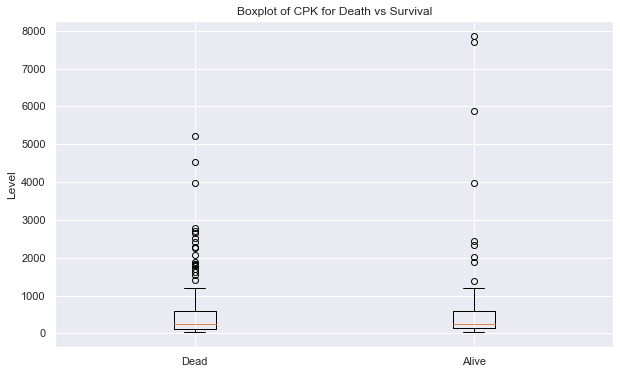

In [6]:
#(2a) CPK Values and boxplot
print(f"CPK Deaths Mean:  {round(df_death['creatinine_phosphokinase'].mean(), 2)}")
print(f"CPK Survive Mean: {round(df_alive['creatinine_phosphokinase'].mean(), 2)}")

# CPK Boxplot
plt.boxplot([df_death['creatinine_phosphokinase'], df_alive['creatinine_phosphokinase']], labels=['Dead','Alive'])
plt.ylabel("Level")
plt.title("Boxplot of CPK for Death vs Survival")
plt.show()

In [7]:
#(2b) CPK P Values
cpk_res = scipy.stats.ttest_ind(df_death['creatinine_phosphokinase'], df_alive['creatinine_phosphokinase'])
print(f"t-value: {cpk_res[0]}\np-value: {cpk_res[1]}")

t-value: -1.0831706812289021
p-value: 0.27961124573614


The difference is significant since the p-value is 0.28 < 0.5

### Preprocessing

In [8]:
# Split features and targets - X: Features, y: Targets
X_logreg = df_raw[features]
y_logreg = df_raw[targets].values.ravel()

# Splitting the dataset into the Training set and Test set where split is 80/20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state = 42)

# Save Test Set
np.savetxt(f"{generate_path}/features_heart_failure_logreg.csv", X_test, delimiter=",")
np.savetxt(f"{generate_path}/targets_heart_failure_logreg.csv",  y_test, delimiter=",")

# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test  = pd.DataFrame(StandardScaler().fit_transform(X_test))

## Logistic Regression

In [9]:
## Generate and train model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()    # instanciating model
logreg.fit(X_train,y_train)      # create model based on data
y_pred = logreg.predict(X_test)  # predict label basted on test

#save trained model
pickle.dump(logreg, open(f'{generate_path}/Model_LogisticRegression.pkl', 'wb')) 

#### Model Evalutation using Confusion Matrix

Confusion Matrix
 [[34  1]
 [18  7]]
Accuracy:	 0.6833333333333333
Precision:	 0.875
Recall:		 0.28
F1 Score:	 0.42424242424242425


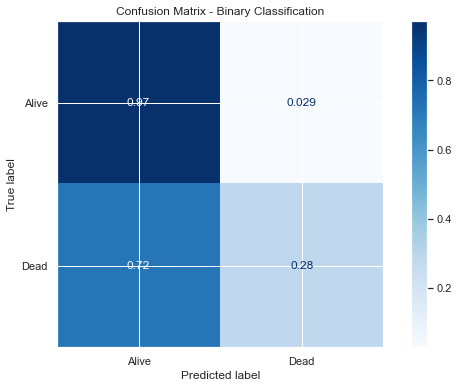

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n', cnf_matrix)

# Plot Confusion Matrix
plt_cnf_matrix = plot_confusion_matrix(logreg, X_test, y_test,
                                       display_labels=['Alive','Dead'],
                                       cmap=plt.cm.Blues,
                                       normalize='true')
plt_cnf_matrix.ax_.set_title('Confusion Matrix - Binary Classification')

# Print Evaluation Metrics
print("Accuracy:\t", accuracy_score( y_test, y_pred))
print("Precision:\t",precision_score(y_test, y_pred))
print("Recall:\t\t",   recall_score( y_test, y_pred))
print("F1 Score:\t", f1_score(       y_test, y_pred))

This model is nowhere near reliable for real-world applications. After running the model multiple times, the confirmation of survival of true alive ranges between 0.8 to 0.9. To obtain the best predictions, the model can be run multiple times until the desired classification is reached. It classifies the patient's survival fairly well but it is not as accurate if the patient dies. It classifies true dead predictions ~60% of the time while getting it incorrectly for the other 40%. Since we are discussing human lives here, a classification of 90% isnt good enough either. 

## K-Nearest Neighbors 

In [87]:
# Some Functions for Showing the Classifier Performance
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score

labels = ['Alive', 'Dead'];
def classifier_performance_knn(model,y_prediction,kval):

    # Develop Confusion Matrix
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=labels,cmap=plt.cm.Blues,normalize='true')
    disp.ax_.set_title(f'Confustion Matrix: KNN where K = {kval}')
    # Calculate Specifity
    TN = disp.confusion_matrix[1][1]
    FP = disp.confusion_matrix[0][1]
    specif = TN / (TN + FP)
    
    # Print performance values and confusion matrix
    print(f'=================================== K = {kval} ===================================')
    print('Confusion Matrix\n', disp.confusion_matrix)
    print('Classification Report: \n', classification_report(y_test, y_prediction, target_names=labels))    
    plt.show()
    print("Accuracy:\t",      round(accuracy_score( y_test, y_prediction), 3))
    print("F1 Score:\t",      round(f1_score(       y_test, y_prediction), 3))
    print("Sensitivity:\t",   round(recall_score(   y_test, y_prediction), 3))
    print("Specificity:\t",   round(specif, 3))

    
    return accuracy_score(y_test, y_prediction)

=================================== K = 1 ===================================
Confusion Matrix
 [[0.88571429 0.11428571]
 [0.68       0.32      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.65      0.89      0.75        35
        Dead       0.67      0.32      0.43        25

    accuracy                           0.65        60
   macro avg       0.66      0.60      0.59        60
weighted avg       0.65      0.65      0.62        60



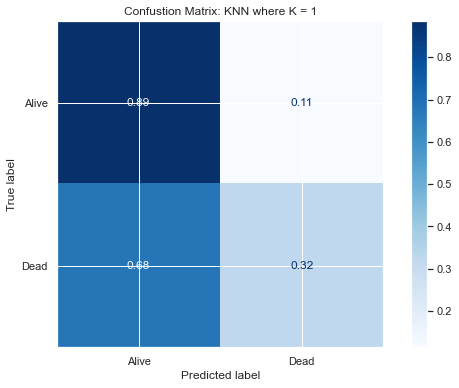

Accuracy:	 0.65
F1 Score:	 0.432
Sensitivity:	 0.32
Specificity:	 0.737
0.01103139
=================================== K = 2 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.92       0.08      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.60      0.97      0.74        35
        Dead       0.67      0.08      0.14        25

    accuracy                           0.60        60
   macro avg       0.63      0.53      0.44        60
weighted avg       0.63      0.60      0.49        60



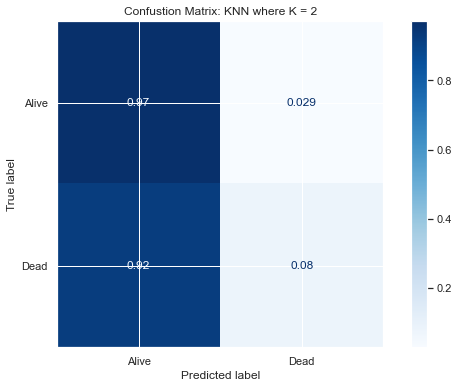

Accuracy:	 0.6
F1 Score:	 0.143
Sensitivity:	 0.08
Specificity:	 0.737
0.0070405
=================================== K = 3 ===================================
Confusion Matrix
 [[0.94285714 0.05714286]
 [0.8        0.2       ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.62      0.94      0.75        35
        Dead       0.71      0.20      0.31        25

    accuracy                           0.63        60
   macro avg       0.67      0.57      0.53        60
weighted avg       0.66      0.63      0.57        60



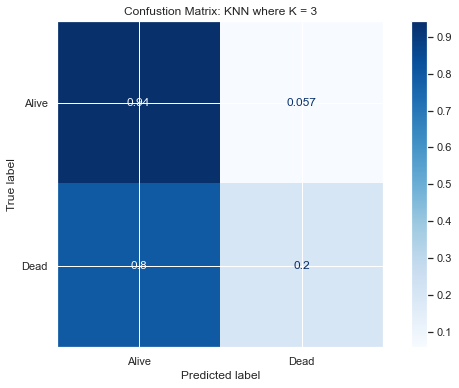

Accuracy:	 0.633
F1 Score:	 0.312
Sensitivity:	 0.2
Specificity:	 0.778
0.00598526
=================================== K = 4 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.84       0.16      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.62      0.97      0.76        35
        Dead       0.80      0.16      0.27        25

    accuracy                           0.63        60
   macro avg       0.71      0.57      0.51        60
weighted avg       0.69      0.63      0.55        60



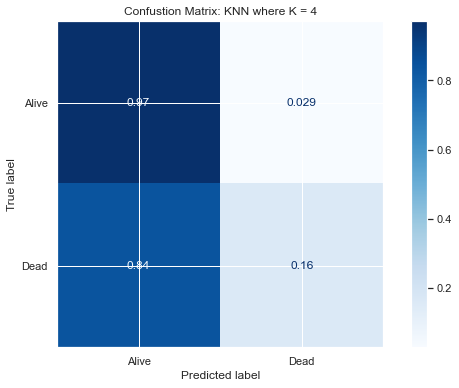

Accuracy:	 0.633
F1 Score:	 0.267
Sensitivity:	 0.16
Specificity:	 0.848
0.00704455
=================================== K = 5 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.72       0.28      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.65      0.97      0.78        35
        Dead       0.88      0.28      0.42        25

    accuracy                           0.68        60
   macro avg       0.76      0.63      0.60        60
weighted avg       0.75      0.68      0.63        60



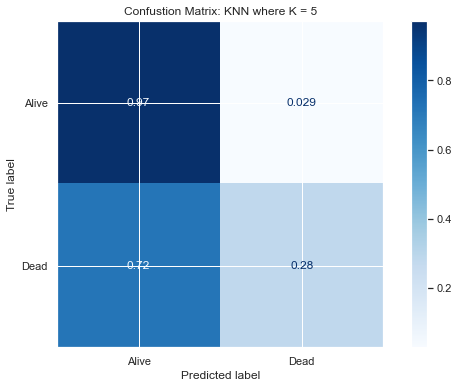

Accuracy:	 0.683
F1 Score:	 0.424
Sensitivity:	 0.28
Specificity:	 0.907
0.00700998
=================================== K = 6 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.84       0.16      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.62      0.97      0.76        35
        Dead       0.80      0.16      0.27        25

    accuracy                           0.63        60
   macro avg       0.71      0.57      0.51        60
weighted avg       0.69      0.63      0.55        60



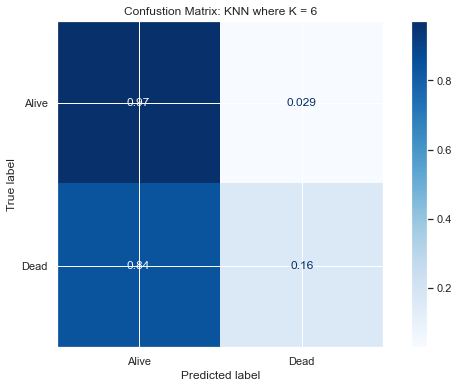

Accuracy:	 0.633
F1 Score:	 0.267
Sensitivity:	 0.16
Specificity:	 0.848
0.00700355
=================================== K = 7 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.72       0.28      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.65      0.97      0.78        35
        Dead       0.88      0.28      0.42        25

    accuracy                           0.68        60
   macro avg       0.76      0.63      0.60        60
weighted avg       0.75      0.68      0.63        60



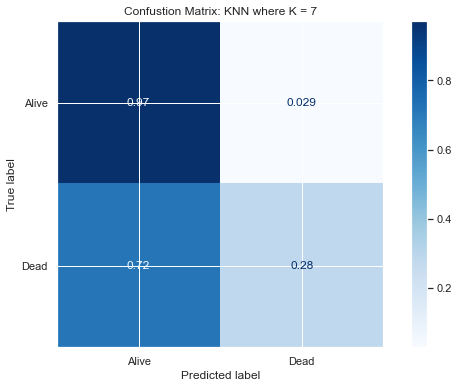

Accuracy:	 0.683
F1 Score:	 0.424
Sensitivity:	 0.28
Specificity:	 0.907
0.00501275
=================================== K = 8 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.84       0.16      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.62      0.97      0.76        35
        Dead       0.80      0.16      0.27        25

    accuracy                           0.63        60
   macro avg       0.71      0.57      0.51        60
weighted avg       0.69      0.63      0.55        60



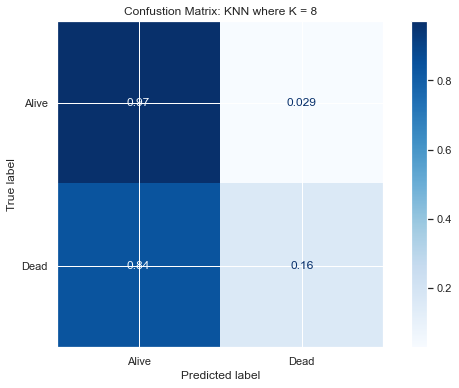

Accuracy:	 0.633
F1 Score:	 0.267
Sensitivity:	 0.16
Specificity:	 0.848
0.01499772
=================================== K = 9 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.84       0.16      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.62      0.97      0.76        35
        Dead       0.80      0.16      0.27        25

    accuracy                           0.63        60
   macro avg       0.71      0.57      0.51        60
weighted avg       0.69      0.63      0.55        60



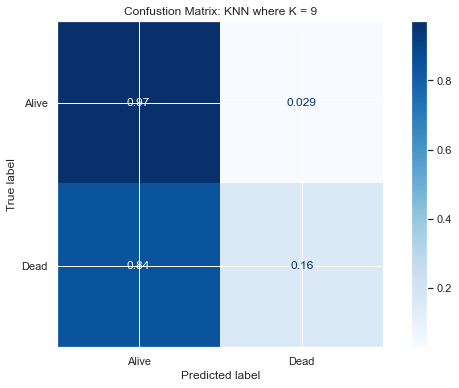

Accuracy:	 0.633
F1 Score:	 0.267
Sensitivity:	 0.16
Specificity:	 0.848
0.00599766
=================================== K = 10 ===================================
Confusion Matrix
 [[0.97142857 0.02857143]
 [0.96       0.04      ]]
Classification Report: 
               precision    recall  f1-score   support

       Alive       0.59      0.97      0.73        35
        Dead       0.50      0.04      0.07        25

    accuracy                           0.58        60
   macro avg       0.54      0.51      0.40        60
weighted avg       0.55      0.58      0.46        60



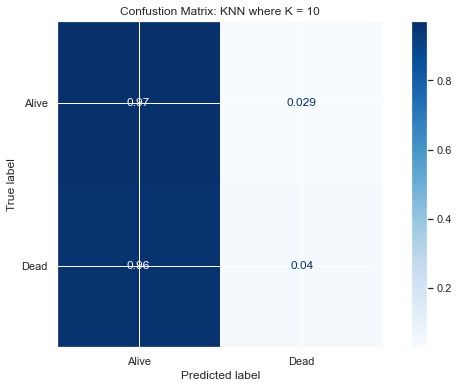

Accuracy:	 0.583
F1 Score:	 0.074
Sensitivity:	 0.04
Specificity:	 0.583
0.0100019


In [88]:
from sklearn.neighbors import KNeighborsClassifier
import time

k_accuracy = []
for K in range(1,11):

    # Instantiating the model (using the default parameters)
    MODEL_KNN = KNeighborsClassifier(n_neighbors=K)      # instanciating model
    MODEL_KNN.fit(X_train,y_train)                       # create model based on data
    
    t_start = time.time() 
    y_pred_KNN = MODEL_KNN.predict(X_test)               # predict label basted on test
    t_end = time.time()

    # Save trained model
    pickle.dump(MODEL_KNN, open(f'{generate_path}/Model_KNN_{K}.pkl', 'wb')) 

    # Generate confusion matrix and performance data
    k_accuracy.append(classifier_performance_knn(MODEL_KNN,y_pred_KNN,K))
    print(round((t_end-t_start), 8))
    


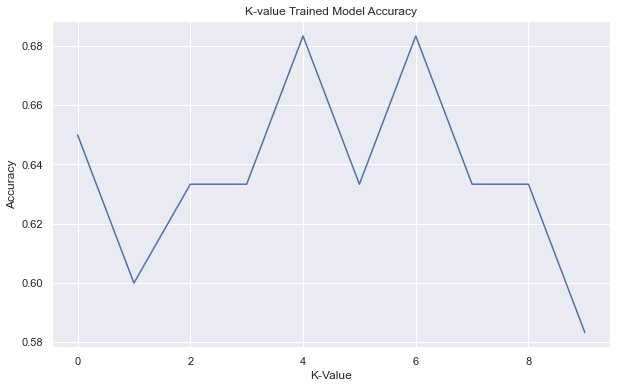

In [86]:
plt.plot(k_accuracy)
plt.title('K-value Trained Model Accuracy')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.show()

The K that resulted in the highest accuracy was K = 6 for this model. For each new model, the accuracy figure is changes. This causes the highest accuracy choice to change too. The accuracy for K=1...10 scales from 0.64 to 0.75 where the peak value spikes or pleateus to values 0.67 and up. 

There is no clear best choice for K. The choice for K depends on the model. It can be infered that the model does not have enough data points to have a consistent accuracy for classification. Similarly, we can infer that various K values can only  be determined by trial and error unique to the model.

## Feature Extraction

In [14]:
from scipy.io import loadmat
from tslearn import metrics
from tslearn.metrics import dtw

# Load all files into variables
files = ["APC", "LBBB", "NORMAL", "PVC", "RBBB"]
categories = {beat:i for i, beat in zip(range(0,len(files)), files)} #dictionary, creates 6th Class column
ecg_data = {}
for name in files:
    ecg_data[name] = {}
    ecg_data[name]["sample"] = loadmat(f'{dataset_multi_path}/{name}_BEATS.mat')[f'{name}_BEATS']
    ecg_data[name]["true"] = loadmat(f'{dataset_multi_path}/{name}.mat')[f'{name}']

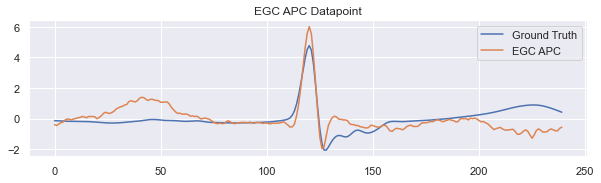

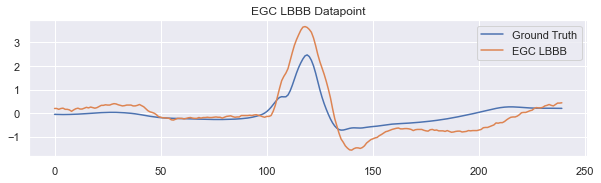

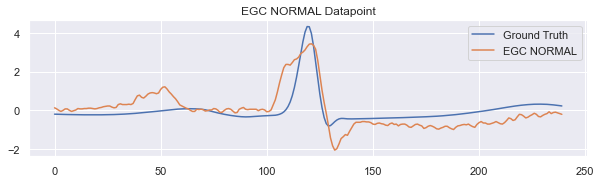

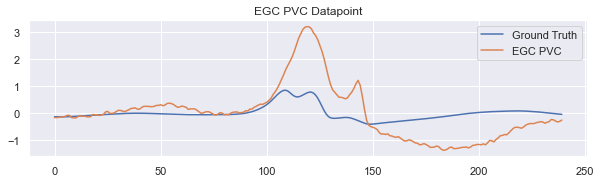

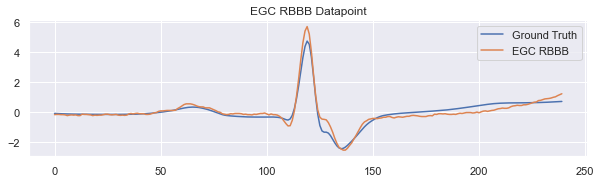

In [15]:
# Visualize ECG Data (optional)
for name in files:
    fig = plt.figure(figsize=(10,2.5))
    plt.plot(ecg_data[name]["true"], label="Ground Truth")
    plt.plot(np.transpose(ecg_data[name]["sample"])[420], label=f"EGC {name}")
    plt.title(f"EGC {name} Datapoint")
    plt.legend()

In [16]:
categories = {beat:i for i, beat in zip(range(0,len(files)), files)}

data_list = []
for beat in files:
    for sample in np.transpose(ecg_data[beat]["sample"]):
        data_row = [dtw(ecg_data[beat_inner]['true'], sample) for beat_inner in files]
        data_row.append(categories[beat])
        data_list.append(data_row)

df_ecg = pd.DataFrame(data_list, columns=[*files, "Class"])

In [17]:
# Show dataframe
df_ecg

,APC,LBBB,NORMAL,PVC,RBBB,Class
0,3.231449,8.845476,7.240612,12.546515,4.274911,0
1,3.496787,9.169499,7.431156,12.756866,4.746585,0
2,5.414016,9.954008,9.355514,13.065383,5.875597,0
3,10.262128,9.351755,6.845544,12.958997,8.786020,0
4,2.623615,8.740587,7.070120,12.649619,3.183230,0
...,...,...,...,...,...,...
9995,4.726825,9.079022,7.572160,12.746662,5.538708,4
9996,4.219710,8.853491,7.073287,12.537512,5.137451,4
9997,4.556547,8.954735,7.517166,12.630535,5.211777,4
9998,3.600130,8.845628,6.582197,12.727262,2.193392,4


In [18]:
# Display Properties
for i in range(0, len(files)):
  print(f"\n========================= Statistics for type {files[i]} =========================")
  display_all(df_ecg.loc[df_ecg['Class'] == i].describe(include='all').T)

# Save dataframe
df_ecg.to_csv(generate_path+"/ecg_dataframe.csv", index=False)
df_ecg = pd.read_csv(generate_path+"/ecg_dataframe.csv")


========================= Statistics for type APC =========================


,count,mean,std,min,25%,50%,75%,max
APC,2000.0,5.027851,2.402160,1.618210,3.405512,4.071044,6.021435,17.916388
LBBB,2000.0,9.052358,0.868904,5.265955,8.722035,8.982747,9.332141,14.500299
NORMAL,2000.0,7.290487,1.461784,1.656783,6.709439,7.374880,7.945497,15.595560
PVC,2000.0,12.689867,0.364341,10.135313,12.554651,12.664539,12.836875,14.714479
RBBB,2000.0,5.657088,2.107174,2.701945,4.341482,4.872975,6.508842,18.159768
Class,2000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



========================= Statistics for type LBBB =========================


,count,mean,std,min,25%,50%,75%,max
APC,2000.0,6.578325,2.859934,3.017257,4.488881,5.499858,7.324879,18.608481
LBBB,2000.0,7.394029,3.312000,2.875416,4.931353,5.720365,9.174497,15.024292
NORMAL,2000.0,6.651859,4.579055,1.721054,3.351443,4.503877,8.619587,17.437089
PVC,2000.0,11.548518,1.163981,10.009245,10.737310,10.956440,12.050703,14.652607
RBBB,2000.0,6.943664,2.551318,3.314491,4.815667,6.395162,8.150536,18.560584
Class,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000



========================= Statistics for type NORMAL =========================


,count,mean,std,min,25%,50%,75%,max
APC,2000.0,5.926885,1.915652,2.023153,4.738279,5.887362,6.719823,16.798989
LBBB,2000.0,8.048190,1.583994,4.595054,6.988426,7.830096,8.706934,14.088051
NORMAL,2000.0,5.388958,2.619107,1.577542,3.697278,4.533761,6.573652,15.873974
PVC,2000.0,12.210457,0.699604,10.353397,11.637363,12.192932,12.778245,14.296567
RBBB,2000.0,6.529973,1.943756,1.769926,5.432322,6.584181,7.518511,16.785009
Class,2000.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000



========================= Statistics for type PVC =========================


,count,mean,std,min,25%,50%,75%,max
APC,2000.0,8.736452,2.012379,3.467414,7.326121,8.346625,10.395671,16.332936
LBBB,2000.0,8.159256,3.181734,2.975661,5.085420,7.207862,11.266254,14.528161
NORMAL,2000.0,8.723294,3.647766,2.097249,5.293611,7.581304,12.381053,15.513377
PVC,2000.0,11.336680,1.318670,8.735164,10.054646,11.200008,12.607230,14.190929
RBBB,2000.0,8.946798,1.976111,3.273444,7.592161,8.655575,10.473217,17.211918
Class,2000.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000



========================= Statistics for type RBBB =========================


,count,mean,std,min,25%,50%,75%,max
APC,2000.0,4.230432,0.921377,3.029476,3.630287,3.927784,4.532329,11.511563
LBBB,2000.0,9.017598,0.314591,7.424394,8.827370,9.001554,9.191988,11.490210
NORMAL,2000.0,7.290978,0.827336,4.256942,6.760577,7.084689,7.474728,12.639153
PVC,2000.0,12.653836,0.281716,10.594574,12.523048,12.728551,12.853225,13.638904
RBBB,2000.0,3.722240,1.332595,1.688329,2.617323,3.278609,4.864845,10.634860
Class,2000.0,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000


# Multi-Class Evaluation

In [19]:
# Load General Libraries
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

files = ["APC", "LBBB", "NORMAL", "PVC", "RBBB"]
f1_result = []

ecg_features = df_ecg[files]
ecg_target   = df_ecg["Class"]
X_train_ecg, X_test_ecg, y_train_ecg, y_test_ecg = train_test_split(ecg_features, ecg_target, test_size=0.2, stratify=df_ecg["Class"])

def classifier_performance_ecg(model, y_pred_ecg, title):
    print('Classification Report: \n', classification_report(y_test_ecg,y_pred_ecg,target_names=files))
    f1_result.append(f1_score(y_test_ecg, y_pred_ecg, average='weighted'))
    
    # Plot normalized confusion matrix
    disp = plot_confusion_matrix(model, X_test_ecg, y_test_ecg,
                                 display_labels=files,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()
    return



## K Nearest Neighbors Classification

Classification Report: 
               precision    recall  f1-score   support

         APC       0.90      0.89      0.89       400
        LBBB       0.93      0.96      0.95       400
      NORMAL       0.90      0.89      0.90       400
         PVC       0.93      0.94      0.93       400
        RBBB       0.96      0.94      0.95       400

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

K Nearest Neighbors Confusion Matrix
[[0.885  0.0125 0.0625 0.015  0.025 ]
 [0.0025 0.96   0.0125 0.025  0.    ]
 [0.05   0.0225 0.8925 0.0275 0.0075]
 [0.005  0.0325 0.02   0.94   0.0025]
 [0.04   0.0025 0.005  0.0075 0.945 ]]


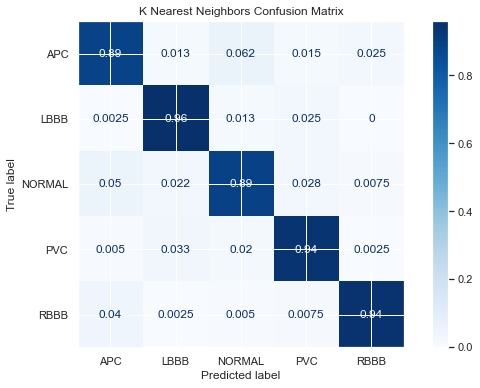

In [20]:
from sklearn.neighbors import KNeighborsClassifier
ECG_MODEL_KNN = KNeighborsClassifier(n_neighbors=5)  # Instantiating the model (using the default parameters)
ECG_MODEL_KNN.fit(X_train_ecg,y_train_ecg)           # Train the Model
y_pred_ecg_KNN = ECG_MODEL_KNN.predict(X_test_ecg)   # Predict the Trained Model on our Test data

# Oputput model
classifier_performance_ecg(ECG_MODEL_KNN, y_pred_ecg_KNN, "K Nearest Neighbors Confusion Matrix")    
pickle.dump(ECG_MODEL_KNN, open(generate_path+'/ECGKNearestNeighbors.pkl', 'wb')) # Save Trained Model


## Decision Tree Classification

Classification Report: 
               precision    recall  f1-score   support

         APC       0.86      0.88      0.87       400
        LBBB       0.92      0.93      0.92       400
      NORMAL       0.86      0.82      0.84       400
         PVC       0.89      0.93      0.91       400
        RBBB       0.95      0.93      0.94       400

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Decision Tree Confusion Matrix
[[0.88   0.0025 0.085  0.0075 0.025 ]
 [0.0025 0.925  0.0225 0.05   0.    ]
 [0.0825 0.0275 0.82   0.0525 0.0175]
 [0.0025 0.0425 0.02   0.9325 0.0025]
 [0.0525 0.005  0.01   0.005  0.9275]]


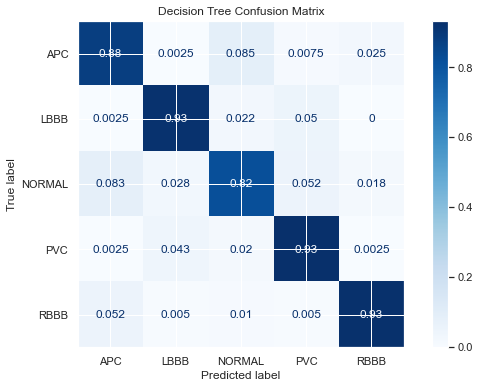

In [21]:
from sklearn.tree import DecisionTreeClassifier
ECG_MODEL_DT = DecisionTreeClassifier()               # Instantiating the model (using the default parameters)
ECG_MODEL_DT.fit(X_train_ecg,y_train_ecg)             # Train the Model
y_pred_ecg_DT = ECG_MODEL_DT.predict(X_test_ecg)      # Predict the Trained Model on our Test data

# Oputput model
classifier_performance_ecg(ECG_MODEL_DT, y_pred_ecg_DT, "Decision Tree Confusion Matrix")    
pickle.dump(ECG_MODEL_DT, open(generate_path+'/ECGDecisionTree.pkl', 'wb')) # Save Trained Model

## Gaussian Naive Bayes Classification

Classification Report: 
               precision    recall  f1-score   support

         APC       0.40      0.22      0.28       400
        LBBB       0.73      0.53      0.61       400
      NORMAL       0.63      0.58      0.61       400
         PVC       0.63      0.75      0.68       400
        RBBB       0.56      0.91      0.69       400

    accuracy                           0.60      2000
   macro avg       0.59      0.60      0.58      2000
weighted avg       0.59      0.60      0.58      2000

Gaussian Naive Bayes Confusion Matrix
[[0.2175 0.0075 0.0525 0.0725 0.65  ]
 [0.04   0.53   0.1825 0.2475 0.    ]
 [0.22   0.0275 0.585  0.1125 0.055 ]
 [0.0075 0.165  0.08   0.7475 0.    ]
 [0.0625 0.     0.0225 0.01   0.905 ]]


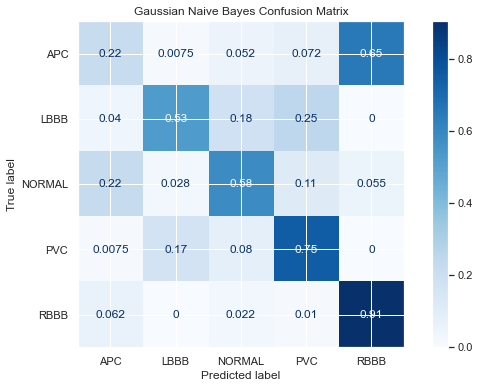

In [22]:
from sklearn.naive_bayes import GaussianNB
ECG_MODEL_GNB = GaussianNB()                       # Instantiating the model (using the default parameters)
ECG_MODEL_GNB.fit(X_train_ecg,y_train_ecg)         # Train the Model
y_pred_ecg_GNB = ECG_MODEL_GNB.predict(X_test_ecg) # Predict the Trained Model on our Test data

# Oputput model
classifier_performance_ecg(ECG_MODEL_GNB, y_pred_ecg_GNB, "Gaussian Naive Bayes Confusion Matrix")    
pickle.dump(ECG_MODEL_GNB, open(generate_path+'/ECGGaussianNaiveBayes.pkl', 'wb')) # Save Trained Model

## Support Vector Machine Classification

Classification Report: 
               precision    recall  f1-score   support

         APC       0.70      0.86      0.77       400
        LBBB       0.90      0.94      0.92       400
      NORMAL       0.83      0.82      0.82       400
         PVC       0.90      0.90      0.90       400
        RBBB       0.97      0.71      0.82       400

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000

Gaussian Naive Bayes Confusion Matrix
[[0.86   0.0075 0.105  0.015  0.0125]
 [0.0025 0.9375 0.025  0.035  0.    ]
 [0.0975 0.035  0.8175 0.045  0.005 ]
 [0.0025 0.065  0.0275 0.9025 0.0025]
 [0.27   0.     0.01   0.005  0.715 ]]


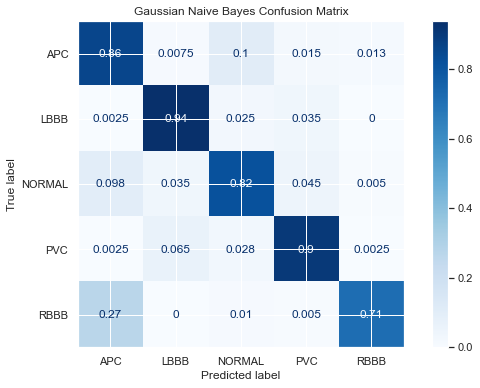

In [23]:
from sklearn.svm import SVC
ECG_MODEL_SVM = SVC()                              # Instantiating the model (using the default parameters)
ECG_MODEL_SVM.fit(X_train_ecg,y_train_ecg)         # Train the Model
y_pred_ecg_SVM = ECG_MODEL_SVM.predict(X_test_ecg) # Predict the Trained Model on our Test data

# Oputput model
classifier_performance_ecg(ECG_MODEL_SVM, y_pred_ecg_SVM, "Gaussian Naive Bayes Confusion Matrix")    
pickle.dump(ECG_MODEL_SVM, open(generate_path+'/ECGSupportVector.pkl', 'wb')) # Save Trained Model

Judging based off the Confusion matricies from the outputs of each models, the K Nearest Neighbors with have the most success of classification. Every model hovers around a precision of 0.9. The model that comes close is the decision tree classification which NORMAL ECG beats with a <0.80 precision. In real world application, I would be testing the dataset with other models and compare more performances. More datapoints would be prefered for a more accurate performance, but the KNN model for this dataset is a good choice.  

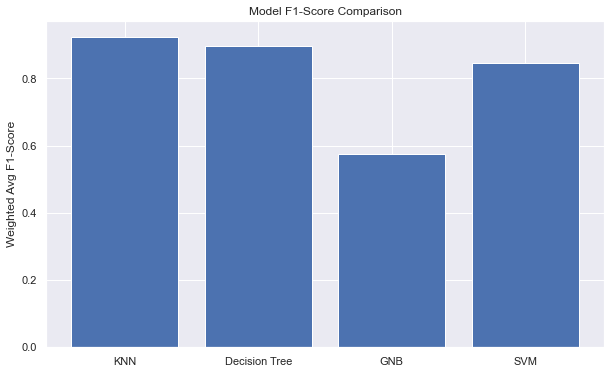

In [24]:
models = ["KNN", "Decision Tree", "GNB", "SVM"]
plt.bar(range(len(models)), f1_result, align='center')
plt.title("Model F1-Score Comparison")
plt.xticks(range(len(models)), models)
plt.ylabel('Weighted Avg F1-Score')
plt.show()